In [34]:
import pickle
import pandas as pd
import numpy as np
import anndata
from scipy.io import mmread
from scipy import sparse

import scanpy as sc

from tools import remove_rare_genes, rnaseqTools
from tools import kobak_tsne, PCA_sklearn
from tools import pearson_residuals, run_glmpca, deviance_residuals
import matplotlib.pyplot as plt
import seaborn as sns
import glmpca

from copy import deepcopy
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import f1_score

In [3]:
adata = anndata.read_csv('datasets/DuoClustering2018/sce_full/sce_full_Zhengmix8eq.csv',first_column_names=True).T
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.filter_cells(adata,min_genes=1)
adata.raw = adata.copy()
adata.shape

filtered out 1 genes that are detected in less than 1 cells


(3994, 15715)

In [4]:
celltypes = []
for cellname in adata.obs_names:
    celltype = ''.join([char for char in cellname if not char.isdigit()])
    celltypes.append(celltype)

adata.obs['celltype'] = celltypes
_,adata.obs['celltype_numeric'] = np.unique(celltypes,return_inverse=True)
colors9 = np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:purple',
 'tab:brown', 'tab:gray', 'tab:olive', 'tab:cyan','tab:red'])

In [5]:
def add_rare_subtype_marker(adata,n_cells_subtype,parent_type,p_marker_exponents,p_short,seed=42,print_ns=False):
    ### make downsampled datasets:
    ad = adata.copy()
    n_markers = len(p_marker_exponents)

    parent_type_idx = np.where(ad.obs['celltype'] == parent_type)[0]

    #randomly pick cells for conversion to rare subtype
    np.random.seed(seed)
    parent_type_idx_shuffled = np.random.permutation(parent_type_idx)
    subtype_idx = parent_type_idx_shuffled[:n_cells_subtype]

    #get their depth and simulate marker count
    subtype_depths = np.sum(ad.X,axis=1)[subtype_idx]
    subtype_means = np.outer(subtype_depths,(10**-p_marker_exponents))
    np.random.seed(seed)
    subtype_marker_counts = np.zeros((ad.shape[0],n_markers))
    subtype_marker_counts[subtype_idx,:] = np.random.poisson(subtype_means)
    
    assert np.all(np.sum(subtype_marker_counts,axis=0)>0)

    #add new column to adata object
    marker_names = ['marker_gene%s'%i for i in range(n_markers)]
    df_marker = pd.DataFrame(subtype_marker_counts,index=adata.obs_names,columns=marker_names)
    
    
    ad_marker = anndata.AnnData(df_marker)
    ad = anndata.concat([ad,ad_marker],axis=1,merge='unique')

    #update celltype label
    subtype_label =  'rare %s subtype' % parent_type
    ad.obs['celltype'][subtype_idx] =subtype_label
    ad.obs['celltype_numeric'][subtype_idx] = max(ad.obs['celltype_numeric'])+1
    
    if print_ns:
        print(np.unique(ad.obs['celltype'],return_counts=True))
        
    ad.uns['addedSubtype'] = dict(subtype_label=subtype_label,
                                  n_cells_subtype=n_cells_subtype,
                                  n_markers=n_markers,
                                  marker_names=marker_names,
                                  parent_type=parent_type,
                                  p_marker_exponents=p_marker_exponents,
                                  p_short=p_short)    
    return ad

In [6]:
ad_subtype_n50p3 = add_rare_subtype_marker(adata,50,'b.cells',np.ones(10)*3,p_short='10-3',seed=42)

/usr/local/lib/python3.8/dist-packages/anndata/_core/merge.py:891: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
<ipython-input-5-0f65f8bc90c5>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad.obs['celltype'][subtype_idx] =subtype_label
<ipython-input-5-0f65f8bc90c5>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad.obs['celltype_numeric'][subtype_idx] = max(ad.obs['celltype_numeric'])+1


## Gene selection

In [7]:
def gene_selection(adata,n_top_genes = 2000):
    
    print(adata.shape)
    adata.raw = adata.copy()    
    
    ### sqrt(CPMedian)
    adata.layers['sqrtnorm'] =  np.sqrt(sc.pp.normalize_total(adata,inplace=False)['X'])
    sqrtnorm_var = np.var(adata.layers['sqrtnorm'],axis=0)
    sqrtcutoff = np.sort(sqrtnorm_var)[-n_top_genes]
    adata.var['hvg_sqrtnorm'] = sqrtnorm_var>=sqrtcutoff    
    
    ### Seurat dispersion gene selection based on logCPMedian counts
    adata.layers['logmedian'] =  sc.pp.normalize_total(adata,inplace=False)['X']
    sc.pp.log1p(adata,layer='logmedian')
    hvg_seurat = sc.pp.highly_variable_genes(adata,flavor='seurat',n_top_genes=n_top_genes,layer='logmedian',inplace=False)
    adata.var['hvg_seurat_logmedian'] = np.array(hvg_seurat['highly_variable'])
    
    ### Seurat v3 gene selection based on raw counts
    hvg_seurat_v3 = sc.pp.highly_variable_genes(adata,flavor='seurat_v3',n_top_genes=n_top_genes,inplace=False)
    adata.var['hvg_seurat_v3'] = np.array(hvg_seurat_v3['highly_variable'])

    ### Pearson residual variance    
    adata.layers['pearson_residuals_theta100'] = pearson_residuals(adata.X,theta=100)
    residual100_var = np.var(adata.layers['pearson_residuals_theta100'],axis=0)
    cutoff100 = np.sort(residual100_var)[-n_top_genes]
    adata.var['hvg_pearson_residuals_theta100'] = residual100_var>=cutoff100
    
    ### Pearson residual variance    
    adata.layers['pearson_residuals_theta10'] = pearson_residuals(adata.X,theta=10)
    residual10_var = np.var(adata.layers['pearson_residuals_theta10'],axis=0)
    cutoff10 = np.sort(residual10_var)[-n_top_genes]
    adata.var['hvg_pearson_residuals_theta10'] = residual10_var>=cutoff10
    
    ### Deviance residual variance    
    adata.layers['deviance_residuals_theta100'] = deviance_residuals(adata.X,theta=100)
    deviance100_var = np.var(adata.layers['deviance_residuals_theta100'],axis=0)
    devcutoff100 = np.sort(deviance100_var)[-n_top_genes]
    adata.var['hvg_deviance_residuals_theta100'] = deviance100_var>=devcutoff100

    
    
    ### Work on subsets
    adata_hvgSqrtnorm = adata.raw.to_adata()[:,adata.var['hvg_sqrtnorm']]
    sc.pp.filter_cells(adata_hvgSqrtnorm,min_genes=1)
    adata_hvgSeurat = adata.raw.to_adata()[:,adata.var['hvg_seurat_logmedian']]
    sc.pp.filter_cells(adata_hvgSeurat,min_genes=1)
    adata_hvgSeuratV3 = adata.raw.to_adata()[:,adata.var['hvg_seurat_v3']]
    sc.pp.filter_cells(adata_hvgSeuratV3,min_genes=1)
    adata_hvgPearson100 = adata.raw.to_adata()[:,adata.var['hvg_pearson_residuals_theta100']]
    sc.pp.filter_cells(adata_hvgPearson100,min_genes=1)
    adata_hvgPearson10 = adata.raw.to_adata()[:,adata.var['hvg_pearson_residuals_theta10']]
    sc.pp.filter_cells(adata_hvgPearson10,min_genes=1)
    adata_hvgDeviance100 = adata.raw.to_adata()[:,adata.var['hvg_deviance_residuals_theta100']]
    sc.pp.filter_cells(adata_hvgDeviance100,min_genes=1)
    


    genemeans_orig = np.mean(adata.X,axis=0)
    genenames_orig = adata.var_names
    
    adata_hvgSqrtnorm.uns['hvg'] = 'Normalization+Sqrt'
    adata_hvgSqrtnorm.uns['hvg_plotlabel'] = 'sqrt(CPMedian)'
    adata_hvgSqrtnorm.uns['hvg_criterion'] = sqrtnorm_var
    adata_hvgSqrtnorm.uns['genemeans_orig'] = genemeans_orig
    adata_hvgSqrtnorm.uns['genenames_orig'] = genenames_orig

    
    adata_hvgSeurat.uns['hvg'] = 'Seurat'
    adata_hvgSeurat.uns['hvg_plotlabel'] = 'Seurat'
    adata_hvgSeurat.uns['hvg_criterion'] = hvg_seurat['dispersions_norm']
    adata_hvgSeurat.uns['genemeans_orig'] = genemeans_orig
    adata_hvgSeurat.uns['genenames_orig'] = genenames_orig

    adata_hvgSeuratV3.uns['hvg'] = 'SeuratV3'
    adata_hvgSeuratV3.uns['hvg_plotlabel'] = 'SeuratV3'
    adata_hvgSeuratV3.uns['hvg_criterion'] = hvg_seurat_v3['variances_norm']
    adata_hvgSeuratV3.uns['genemeans_orig'] = genemeans_orig
    adata_hvgSeuratV3.uns['genenames_orig'] = genenames_orig

    adata_hvgPearson100.uns['hvg'] = 'Pearson (theta=100)'
    adata_hvgPearson100.uns['hvg_plotlabel'] = r'Pearson Residuals ($\theta=100$)'
    adata_hvgPearson100.uns['hvg_criterion'] = residual100_var
    adata_hvgPearson100.uns['genemeans_orig'] = genemeans_orig
    adata_hvgPearson100.uns['genenames_orig'] = genenames_orig
    
    adata_hvgPearson10.uns['hvg'] = 'Pearson (theta=10)'
    adata_hvgPearson10.uns['hvg_plotlabel'] = r'Pearson Residuals ($\theta=10)$'
    adata_hvgPearson10.uns['hvg_criterion'] = residual10_var
    adata_hvgPearson10.uns['genemeans_orig'] = genemeans_orig
    adata_hvgPearson10.uns['genenames_orig'] = genenames_orig

    adata_hvgDeviance100.uns['hvg'] = 'Deviance (theta=100)'
    adata_hvgDeviance100.uns['hvg_plotlabel'] = r'Deviance Residuals ($\theta=100$)'
    adata_hvgDeviance100.uns['hvg_criterion'] = deviance100_var
    adata_hvgDeviance100.uns['genemeans_orig'] = genemeans_orig
    adata_hvgDeviance100.uns['genenames_orig'] = genenames_orig

    
    return [adata_hvgSqrtnorm, adata_hvgSeurat, adata_hvgSeuratV3, adata_hvgPearson100, adata_hvgPearson10, adata_hvgDeviance100]

In [8]:
n_top_genes = 2000
all_datasets = gene_selection(ad_subtype_n50p3,n_top_genes = n_top_genes)

normalizing counts per cell


(3994, 15725)


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/gpfs01/berens/user/jlause/.local/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Setting 678 negative sqrt term values to 0 (0.000011%)


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [9]:
_=[print(ad.uns['hvg'],
         'n',ad.uns['addedSubtype']['n_cells_subtype'],
         'p 10**-',ad.uns['addedSubtype']['p_short'],
         'has marker gene:',np.sum(np.isin(ad.var_names,ad.uns['addedSubtype']['marker_names']))) for ad in all_datasets]

Normalization+Sqrt n 50 p 10**- 10-3 has marker gene: 0
Seurat n 50 p 10**- 10-3 has marker gene: 10
SeuratV3 n 50 p 10**- 10-3 has marker gene: 10
Pearson (theta=100) n 50 p 10**- 10-3 has marker gene: 10
Pearson (theta=10) n 50 p 10**- 10-3 has marker gene: 10
Deviance (theta=100) n 50 p 10**- 10-3 has marker gene: 0


## Dimensionality reduction

In [10]:
n_comps = 50

In [11]:
def scale_pca_output(X):
    return X / np.max(np.abs(X))
def get_pca_init_for_tSNE(X):
    return X[:,:2] / np.std(X[:,0]) * .0001

In [12]:
def logcpm_PCA(adata):
    adata = adata.copy()
    adata.layers['logCPM'] =  sc.pp.normalize_total(adata,target_sum=1e6,inplace=False)['X']
    sc.pp.log1p(adata,layer='logCPM')
    return sc.pp.pca(adata.layers['logCPM'],random_state=42,n_comps=n_comps)

In [13]:
def logmedian_PCA(adata):
    adata = adata.copy()
    adata.layers['logmedian'] =  sc.pp.normalize_total(adata,inplace=False)['X']
    sc.pp.log1p(adata,layer='logmedian')
    return sc.pp.pca(adata.layers['logmedian'],random_state=42,n_comps=n_comps)

In [14]:
def sqrtnorm_PCA(adata):
    adata = adata.copy()
    adata.layers['sqrtnorm'] =  np.sqrt(sc.pp.normalize_total(adata,inplace=False)['X'])
    return sc.pp.pca(adata.layers['sqrtnorm'],random_state=42,n_comps=n_comps)

In [15]:
def pearson_residuals_PCA(adata,theta=100):
    adata = adata.copy()    
    return sc.pp.pca(pearson_residuals(adata.X,theta),random_state=42,n_comps=n_comps)

In [16]:
def deviance_residuals_PCA(adata,theta=100):
    adata = adata.copy()    
    return sc.pp.pca(deviance_residuals(adata.X,theta),random_state=42,n_comps=n_comps)

In [17]:
def get_tag(ad):
    hvg = ad.uns['hvg']
    
    parent_type = ad.uns['addedSubtype']['parent_type']
    n = ad.uns['addedSubtype']['n_cells_subtype']
    n_markers = ad.uns['addedSubtype']['n_markers']

    p = ad.uns['addedSubtype']['p_short']
    subtype_tag = 'rare%ssubtype_nCells%u_nMarkers%u_%s' % (parent_type, n, n_markers, p)
    
    tag = 'zheng8eq_%s_hvg%s_ngenes%u_dim%u_' % (subtype_tag,hvg,n_top_genes,n_comps)
    return tag

In [18]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
for ad in all_datasets:
    
    tag = get_tag(ad)
    
    # NB GLM PCA with fit theta required higher penalty to converge for some HVG selection methods
    if ad.uns['hvg'] in ['Pearson (theta=10)','Deviance (theta=100)']:   
        run_glmpca(ad.X,n_PCs=n_comps,fam='nb',optimize_nb_theta=True,dataset_label = tag,penalty=10)
        
    # otherwise default penalty is used
    else:
        run_glmpca(ad.X,n_PCs=n_comps,fam='nb',optimize_nb_theta=True,dataset_label = tag,penalty=1)
        
    run_glmpca(ad.X,n_PCs=n_comps,fam='nb',optimize_nb_theta=False,theta=100,dataset_label = tag,penalty=1)
    run_glmpca(ad.X,n_PCs=n_comps,fam='poi',dataset_label = tag,penalty=1)

In [19]:
for ad in all_datasets:
    
    tag = get_tag(ad)
    
    ad.obsm['pca_logcpm'] = scale_pca_output(logcpm_PCA(ad))
    ad.obsm['pca_logmedian'] = scale_pca_output(logmedian_PCA(ad))
    ad.obsm['pca_sqrtnorm'] = scale_pca_output(sqrtnorm_PCA(ad))
    ad.obsm['pca_pr100'] = scale_pca_output(pearson_residuals_PCA(ad,theta=100))
    ad.obsm['pca_pr10'] = scale_pca_output(pearson_residuals_PCA(ad,theta=10))
    ad.obsm['pca_dr100'] = scale_pca_output(deviance_residuals_PCA(ad,theta=100))
    
    with open('glmpca_results/%sglmpca-py_poi_penalty1.pickle' % tag,'rb') as f:
        ad.obsm['glmpca_poi'] = scale_pca_output(pickle.load(f)['factors'])
    with open('glmpca_results/%sglmpca-py_nb_fixedTheta100_penalty1.pickle' % tag,'rb') as f:
        ad.obsm['glmpca_nbfixed'] = scale_pca_output(pickle.load(f)['factors'])
        
    if ad.uns['hvg'] in ['Pearson (theta=10)','Deviance (theta=100)']: 
        with open('glmpca_results/%sglmpca-py_nb_penalty10.pickle' % tag,'rb') as f:
            glmpca_nb=pickle.load(f)
    else:
        with open('glmpca_results/%sglmpca-py_nb_penalty1.pickle' % tag,'rb') as f:
            glmpca_nb=pickle.load(f)

    ad.obsm['glmpca_nb'] = scale_pca_output(glmpca_nb['factors'])
    ad.uns['glmpca_nb_theta'] = glmpca_nb['nb_theta']

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50


Setting 698 negative sqrt term values to 0 (0.000087%)


    finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50


Setting 42 negative sqrt term values to 0 (0.000005%)


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50


Setting 104 negative sqrt term values to 0 (0.000013%)


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50


Setting 349 negative sqrt term values to 0 (0.000044%)


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing PCA
    with n_comps=50


Setting 128 negative sqrt term values to 0 (0.000016%)


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50


Setting 657 negative sqrt term values to 0 (0.000082%)


    finished (0:00:00)


## Compute/Load tSNEs

In [20]:
## setup shared init for tSNE
hvgs=[]
ns=[]
ps=[]
for ad in all_datasets:
    hvgs.append(ad.uns['hvg'])
    ns.append(ad.uns['addedSubtype']['n_cells_subtype'])
    ps.append(max(ad.uns['addedSubtype']['p_marker_exponents']))
hvgs = np.array(hvgs)
ns = np.array(ns)
ps = np.array(ps)

shared_init_dataset_id = np.where(hvgs=='Normalization+Sqrt')[0][0]
shared_init = get_pca_init_for_tSNE(all_datasets[shared_init_dataset_id].obsm['pca_sqrtnorm'])

In [21]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
for ad in all_datasets:
    
    tag = get_tag(ad)

    _ = kobak_tsne(ad.obsm['pca_logcpm'],name='%s_pcaLogcpm_sharedInit' % tag,do_pca=False,init=shared_init)
    _ = kobak_tsne(ad.obsm['pca_logmedian'],name='%s_pcaLogmedian_sharedInit' % tag,do_pca=False,init=shared_init)
    _ = kobak_tsne(ad.obsm['pca_sqrtnorm'],name='%s_pcaSqrtnorm_sharedInit' % tag,do_pca=False,init=shared_init)
    _ = kobak_tsne(ad.obsm['pca_pr100'],name='%s_pcaPearson100_sharedInit' % tag,do_pca=False,init=shared_init)
    _ = kobak_tsne(ad.obsm['pca_pr10'],name='%s_pcaPearson10_sharedInit' % tag,do_pca=False,init=shared_init)
    _ = kobak_tsne(ad.obsm['pca_dr100'],name='%s_pcaDeviance100_sharedInit' % tag,do_pca=False,init=shared_init)

    _ = kobak_tsne(ad.obsm['glmpca_poi'],name='%s_glmpcaPoi_sharedInit' % tag,do_pca=False,init=shared_init)
    _ = kobak_tsne(ad.obsm['glmpca_nb'],name='%s_glmpcaNB_sharedInit' % tag,do_pca=False,init=shared_init)
    _ = kobak_tsne(ad.obsm['glmpca_nbfixed'],name='%s_glmpcaNBFixed_sharedInit' % tag,do_pca=False,init=shared_init)

In [22]:
for ad in all_datasets:
    
    tag = get_tag(ad)
    
    with open('tsne/tsne_%s_pcaLogcpm_sharedInit.pickle'%tag,'rb') as f:
        ad.obsm['pca_logcpm_tsne'] = pickle.load(f)['coords']
    with open('tsne/tsne_%s_pcaLogmedian_sharedInit.pickle'%tag,'rb') as f:
        ad.obsm['pca_logmedian_tsne'] = pickle.load(f)['coords']
    with open('tsne/tsne_%s_pcaSqrtnorm_sharedInit.pickle'%tag,'rb') as f:
        ad.obsm['pca_sqrtnorm_tsne'] = pickle.load(f)['coords']
        
    with open('tsne/tsne_%s_pcaPearson100_sharedInit.pickle'%tag,'rb') as f:
        ad.obsm['pca_pr100_tsne'] = pickle.load(f)['coords']
    with open('tsne/tsne_%s_pcaPearson10_sharedInit.pickle'%tag,'rb') as f:
        ad.obsm['pca_pr10_tsne'] = pickle.load(f)['coords']
    with open('tsne/tsne_%s_pcaDeviance100_sharedInit.pickle'%tag,'rb') as f:
        ad.obsm['pca_dr100_tsne'] = pickle.load(f)['coords']
        
    with open('tsne/tsne_%s_glmpcaPoi_sharedInit.pickle'%tag,'rb') as f:
        ad.obsm['glmpca_poi_tsne'] = pickle.load(f)['coords']
    with open('tsne/tsne_%s_glmpcaNB_sharedInit.pickle'%tag,'rb') as f:
        ad.obsm['glmpca_nb_tsne'] = pickle.load(f)['coords']
    with open('tsne/tsne_%s_glmpcaNBFixed_sharedInit.pickle'%tag,'rb') as f:
        ad.obsm['glmpca_nbfixed_tsne'] = pickle.load(f)['coords']

## Figure S8

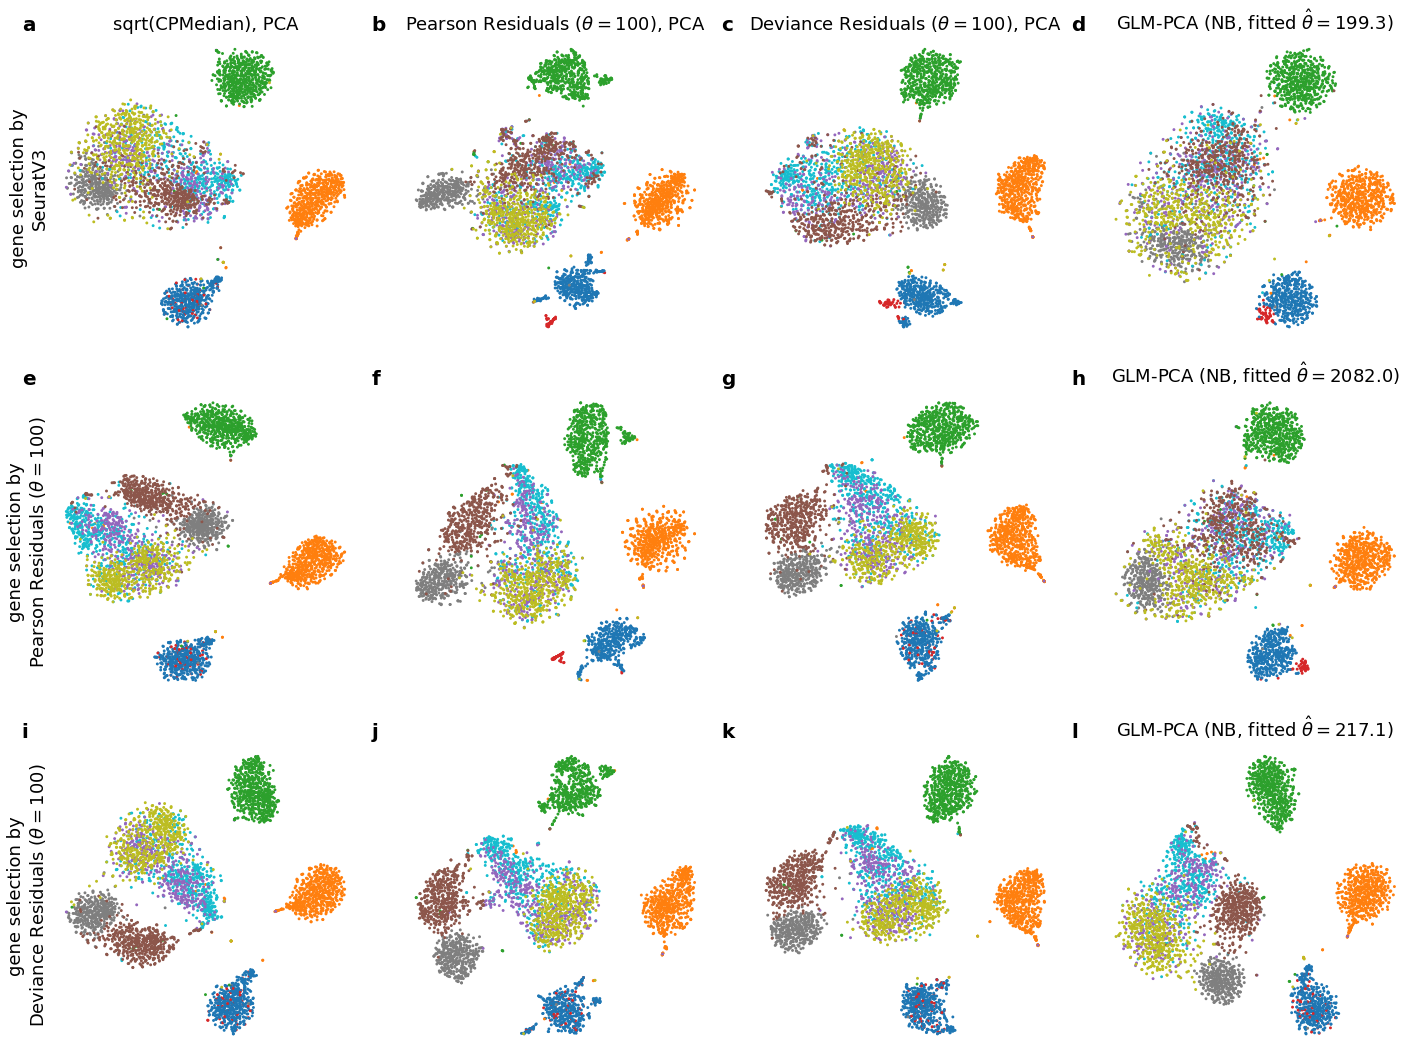

In [23]:
clm_keys = ['pca_sqrtnorm_tsne', 
            
            'pca_pr100_tsne',
            'pca_dr100_tsne',

            'glmpca_nb_tsne']

titleletter_loc = (-0.1,1.015)
title_fontsize = 20
title_fontweight = "bold"

letters = ['a','b','c', 'd',
           'e','f','g','h',
           'i','j','k','l']

with sns.plotting_context('talk'):
    
    fig,axes = plt.subplots(3,4,figsize=(20,15))

    row=0
    i=0
    for _,ad in enumerate(all_datasets):
        
        
        hvg = ad.uns['hvg']
        
        if not hvg in ['SeuratV3', 'Pearson (theta=100)', 'Deviance (theta=100)']:
            continue
        
        clm_titles = ['sqrt(CPMedian), PCA',              
              r'Pearson Residuals ($\theta=100$), PCA', 
              r'Deviance Residuals ($\theta=100$), PCA',        
              r'GLM-PCA (NB, fitted $\hat\theta=%.1f$)' % (ad.uns['glmpca_nb_theta'])]
        
        
        
        for clm,(clm_key, clm_title) in enumerate(zip(clm_keys, clm_titles)):
                        
            celltypes_numeric = ad.obs['celltype_numeric']
            axes[row,clm].scatter(*ad.obsm[clm_key].T,c=colors9[celltypes_numeric],s=2)
            axes[row,clm].text(*titleletter_loc,letters[i],transform=axes[row,clm].transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
            i+=1
            if row==0 or clm_key == 'glmpca_nb_tsne':                
                axes[row,clm].set_title(clm_title)
            
        
            if clm==0:
                axes[row,clm].set_ylabel('gene selection by\n%s'%(ad.uns['hvg_plotlabel']))
                axes[row,clm].xaxis.set_ticks([])
                axes[row,clm].yaxis.set_ticks([])
                axes[row,clm].spines['top'].set_visible(False)
                axes[row,clm].spines['right'].set_visible(False)
                axes[row,clm].spines['bottom'].set_visible(False)
                axes[row,clm].spines['left'].set_visible(False)
            else:
                axes[row,clm].axis('off')
        row+=1
    plt.tight_layout()

#### Additional figure of all tSNEs corresponding to all cells of the matrix in Figure 5c

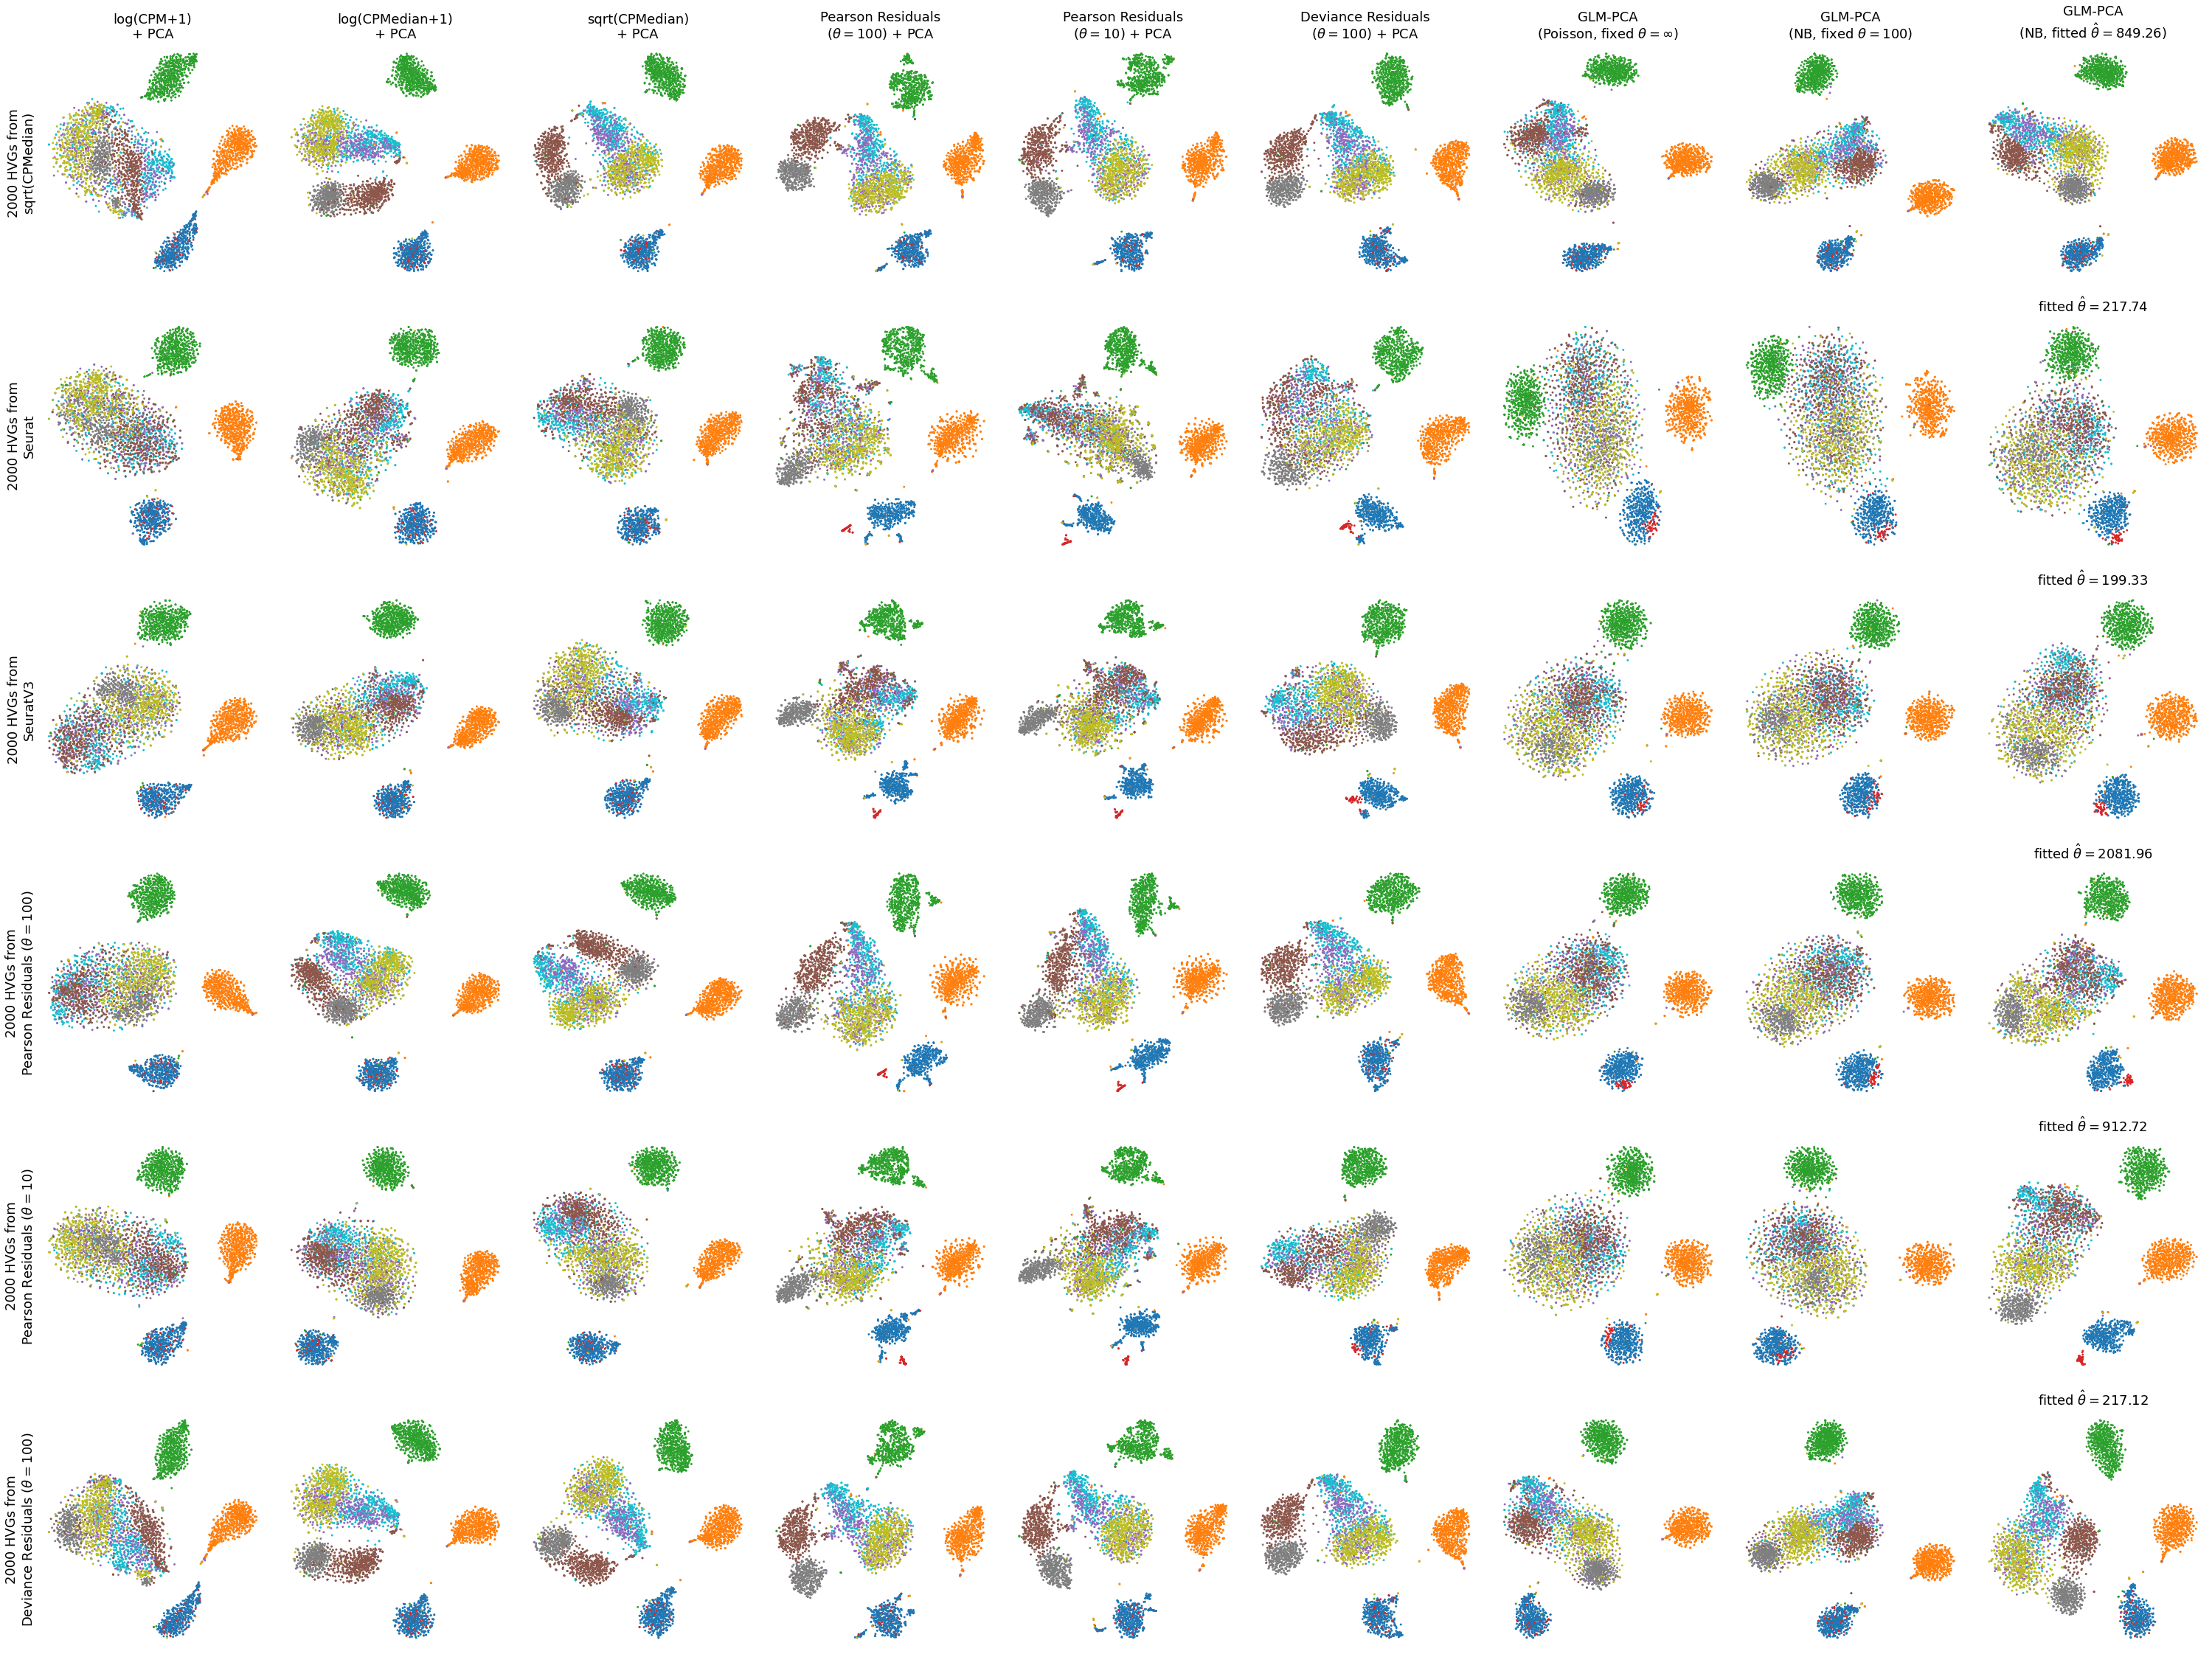

In [24]:
clm_keys = ['pca_logcpm_tsne',
            'pca_logmedian_tsne',
            'pca_sqrtnorm_tsne', 
            
            'pca_pr100_tsne',
            'pca_pr10_tsne',
            'pca_dr100_tsne',
            
            'glmpca_poi_tsne',
            'glmpca_nbfixed_tsne',
            'glmpca_nb_tsne']

with sns.plotting_context('talk'):
    
    fig,axes = plt.subplots(6,9,figsize=(60*0.7,45*0.7))

    
    for row,ad in enumerate(all_datasets):
        
        
        hvg = ad.uns['hvg']
        
        clm_titles = ['log(CPM+1)\n+ PCA', 
              'log(CPMedian+1)\n+ PCA', 
              'sqrt(CPMedian)\n+ PCA',
              
              'Pearson Residuals\n'+r'($\theta=100$) + PCA', 
              'Pearson Residuals\n'+r'($\theta=10$) + PCA', 
              'Deviance Residuals\n'+r'($\theta=100$) + PCA', 
              
              'GLM-PCA\n' r'(Poisson, fixed $\theta=\infty$)',
              'GLM-PCA\n' r'(NB, fixed $\theta=100$)',
              'GLM-PCA\n' r'(NB, fitted $\hat\theta=%.2f$)' % ad.uns['glmpca_nb_theta']]
        
        
        
        for clm,(clm_key, clm_title) in enumerate(zip(clm_keys, clm_titles)):
                        
            celltypes_numeric = ad.obs['celltype_numeric']
            axes[row,clm].scatter(*ad.obsm[clm_key].T,c=colors9[celltypes_numeric],s=2)
            
            if row==0:                
                axes[row,clm].set_title(clm_title)
            elif clm_key=='glmpca_nb_tsne':
                axes[row,clm].set_title(r'fitted $\hat\theta=%.2f$' % ad.uns['glmpca_nb_theta'],)
            
        
            if clm==0:
                axes[row,clm].set_ylabel('%u HVGs from\n%s'%(n_top_genes,ad.uns['hvg_plotlabel']))
                axes[row,clm].xaxis.set_ticks([])
                axes[row,clm].yaxis.set_ticks([])
                axes[row,clm].spines['top'].set_visible(False)
                axes[row,clm].spines['right'].set_visible(False)
                axes[row,clm].spines['bottom'].set_visible(False)
                axes[row,clm].spines['left'].set_visible(False)
            else:
                axes[row,clm].axis('off')
        plt.tight_layout()

#### Additional gene selection figure highlighting the marker genes of the artificially added rare subpopulation

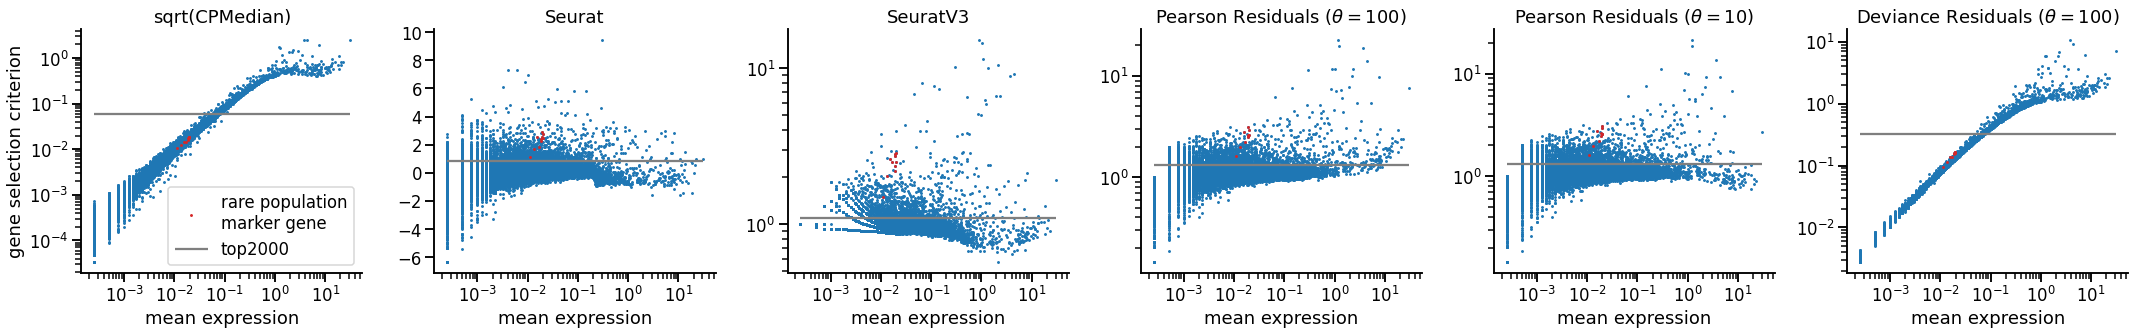

In [25]:
with sns.plotting_context('talk'):
    
    fig,axes = plt.subplots(1,6,figsize=(30,5))


    for clm,ad in enumerate(all_datasets):
        
        hvg = ad.uns['hvg']
        
        hvg_criterion = ad.uns['hvg_criterion']        
        cutoff = np.sort(hvg_criterion)[-n_top_genes]
        means=ad.uns['genemeans_orig']

        marker_genes_idx = np.isin(ad.uns['genenames_orig'],ad.uns['addedSubtype']['marker_names'])
        axes[clm].scatter(means,hvg_criterion,s=2)
        axes[clm].scatter(means[marker_genes_idx],hvg_criterion[marker_genes_idx],s=2,c='tab:red',label='rare population\nmarker gene')
        axes[clm].hlines(cutoff,min(means),max(means),'tab:gray',label='top%u' % n_top_genes)
        axes[clm].set_xscale('log')
        axes[clm].set_yscale('log')

        axes[clm].set_title(ad.uns['hvg_plotlabel'])


        if hvg=='Seurat':
            axes[clm].set_yscale('linear')


        if clm==0:
            axes[clm].set_ylabel('gene selection criterion')
            axes[clm].legend()
        axes[clm].set_xlabel('mean expression')
            


    sns.despine()
    plt.tight_layout()

## run kNN to assess cluster separation

In [26]:
k=15

In [27]:
dim_reduction_keys_orig = ['pca_logcpm','pca_logmedian','pca_sqrtnorm','pca_pr100','pca_pr10','pca_dr100','glmpca_poi','glmpca_nb','glmpca_nbfixed']
dim_reductions_titles_orig = np.array(['log(CPM+1), PCA',
                                  'log(CPMedian+1), PCA',
                                  'sqrt(CPMedian), PCA',
                                  r'Pearson res.($\theta=100$), PCA',
                                  r'Pearson res.($\theta=10$), PCA',
                                  r'Deviance res.($\theta=100$), PCA',
                                  r'GLM-PCA (Poisson, $\theta=\infty$)',
                                  r'GLM-PCA (NB, $\hat\theta$ fit)',
                                  r'GLM-PCA (NB, $\theta=100$)'])
dim_red_title_mapping = {k:t for k,t in zip(dim_reduction_keys_orig,dim_reductions_titles_orig)}

In [28]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
results = []
for ad in all_datasets:
    
    labels = np.array(ad.obs['celltype_numeric'])
    print(ad.uns['hvg'])
    
    for dim_reduction in dim_reduction_keys_orig:
        
        print(dim_reduction)
        
        X = ad.obsm[dim_reduction]

        loo = LeaveOneOut()
        predictions = np.nan * np.ones(labels.shape)

        for train_idx,test_idx in loo.split(X,labels):
            
            knn = KNeighborsClassifier(n_neighbors=k)
            X_train, X_test = X[train_idx], X[test_idx]
            labels_train = labels[train_idx]
            knn.fit(X_train,labels_train)
            predictions[test_idx] = knn.predict(X_test)

        accuracy = np.mean(labels==predictions)
        f1macro =f1_score(labels,predictions,average='macro')

        result = dict(gene_selection_type=ad.uns['hvg'],
                       dim_reduction=dim_reduction,
                       k=k,
                       accuracy=accuracy,
                       f1macro=f1macro,
                       predictions=predictions)
        
        results.append(result)

np.save('datasets/DuoClustering2018/sce_full/zheng8_addrarepopulation_knn-k%u_dim%u' % (k, n_comps), results, )  

#### Additional figure showing simple accuracy and F1 score of the kNN classifier

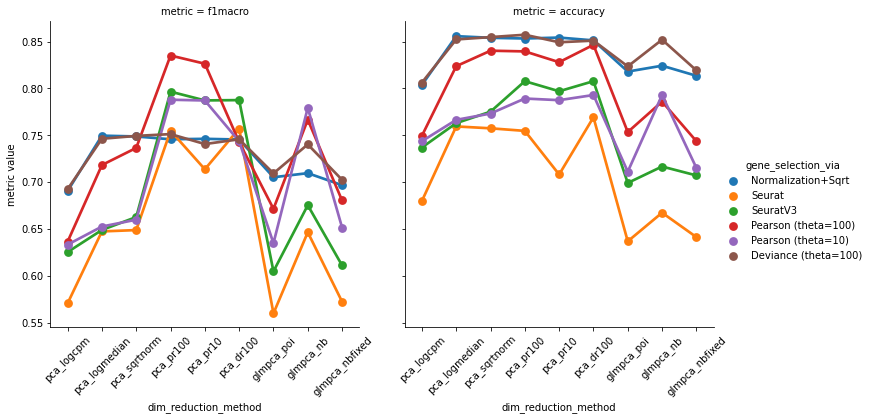

In [29]:
res_k15 = np.load('datasets/DuoClustering2018/sce_full/zheng8_addrarepopulation_knn-k%u_dim%u.npy' % (k,n_comps),allow_pickle=True)

def get_plot_df(res):
    gene_selection_via = []
    k = []
    dim_reduction_method = []
    f1macro = []
    accuracy = []
    for r in res:
        gene_selection_via.append(r['gene_selection_type'])
        k.append(r['k'])
        dim_reduction_method.append(r['dim_reduction'])
        f1macro.append(r['f1macro'])
        accuracy.append(r['accuracy'])

    data_dict = dict(gene_selection_via=gene_selection_via,
                     k=k,
                     dim_reduction_method=dim_reduction_method,
                     f1macro=f1macro,
                     accuracy=accuracy)
    data = pd.DataFrame(data_dict)
    return data.melt(id_vars=['gene_selection_via','k','dim_reduction_method'])

df = get_plot_df(res_k15)
df = df.reset_index(drop=True)
df = df.rename(columns={'variable':'metric','value':'metric value'})
plot = sns.catplot(x='dim_reduction_method',y='metric value',hue='gene_selection_via',data=df,kind='point',col='metric',)
for ax in plot.axes.flatten():
    for item in ax.get_xticklabels():
        item.set_rotation(45)

In [30]:
gene_selections_keys_orig = np.array(['Deviance (theta=100)', 'Normalization+Sqrt', 'Seurat', 'SeuratV3', 'Pearson (theta=10)', 'Pearson (theta=100)'])
gene_selections_titles_orig = np.array(['Deviance Residuals\n'+r'($\theta=100$)', 'sqrt(CPMedian)', 'Seurat', 'SeuratV3', 'Pearson Residuals\n'+r'($\theta=10$)', 'Pearson Residuals\n'+r'($\theta=100)$'])
gensel_title_mapping = {k:t for k,t in zip(gene_selections_keys_orig,gene_selections_titles_orig)}

In [31]:
#ordering of rows/columns in Figure 5
order_dimred = np.array([4, 5, 8, 3, 6, 7, 0, 1, 2])
order_gensel = np.array([0, 1, 4, 5, 2, 3])
gene_selections = np.unique(df['gene_selection_via'])[order_gensel]
gene_selections_titles = np.array([gensel_title_mapping[k] for k in gene_selections]).astype(object)
dim_reductions = np.unique(df['dim_reduction_method'])[order_dimred]
dim_reductions_titles = np.array([dim_red_title_mapping[k] for k in dim_reductions]).astype(object)

f1=np.nan*np.ones((len(gene_selections),len(dim_reductions)))
acc=np.nan*np.ones((len(gene_selections),len(dim_reductions)))

for row,gene_selection in enumerate(gene_selections):
    for clm,dim_reduction in enumerate(dim_reductions):

        query_str = 'gene_selection_via==@gene_selection & k==@k & dim_reduction_method==@dim_reduction'
        f1[row,clm] = df.query(query_str + '& metric=="f1macro"')['metric value']
        acc[row,clm] = df.query(query_str + '& metric=="accuracy"')['metric value']

In [32]:
def plot_matrix(data,ax=None):
    
    if ax is None:
        ax=plt.gca()
    
    im = ax.imshow(data)
    ax.set_xticks(ticks=np.arange(len(dim_reductions)))
    ax.set_xticklabels(labels=dim_reductions_titles,rotation=45,ha='right',fontsize=10)
    ax.set_yticks(ticks=np.arange(len(gene_selections)))
    ax.set_yticklabels(labels=gene_selections_titles,fontsize=10)
    
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("left")
    ax.set_ylabel('gene selection',labelpad=15)
    ax.set_xlabel('data transformation')
    ax.tick_params(axis='both', which='both',length=0)

    
    
    for row in range(len(gene_selections)):
        for clm in range(len(dim_reductions)):
            ax.text(clm,row,'%.2f'%data[row,clm],ha='center',va='center',fontsize=8)

## Figure 5

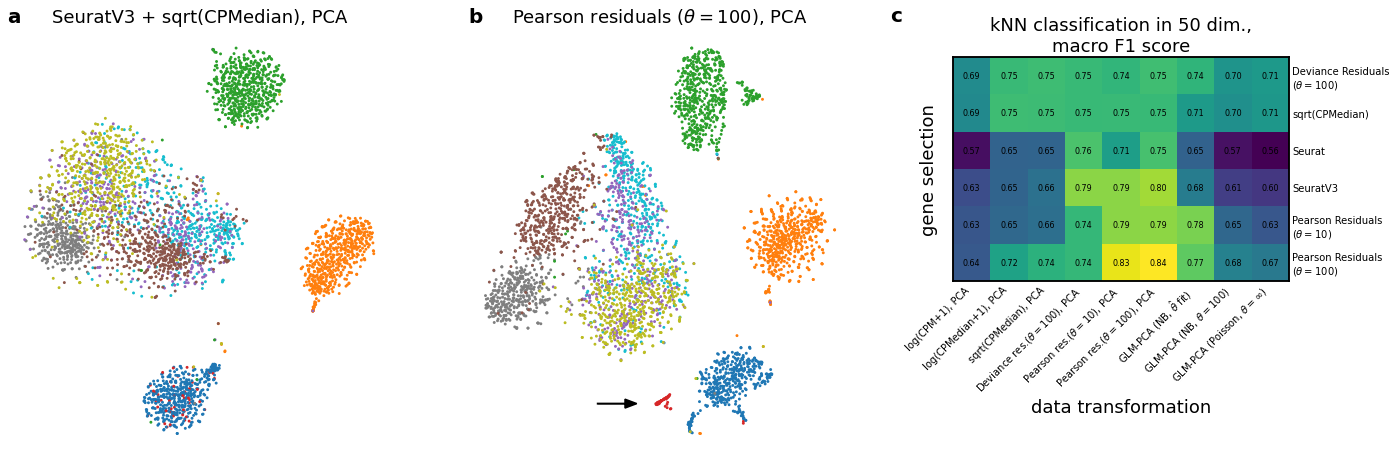

In [33]:
with sns.plotting_context('talk'):
    titleletter_loc = (0,1.015)
    title_fontsize = 20
    title_fontweight = "bold"

    scale = 1.3
    plt.figure(figsize=(18*scale,6*scale))
    ax1 = plt.subplot2grid(shape=(15, 3), loc=(0, 0), rowspan=15)
    ax2 = plt.subplot2grid(shape=(15, 3), loc=(0, 1), rowspan=15)
    ax4 = plt.subplot2grid(shape=(15, 3), loc=(0, 2), rowspan=2)
    ax3 = plt.subplot2grid(shape=(15, 3), loc=(1, 2), rowspan=8)

    seuratv3_id = np.where(hvgs=='SeuratV3')[0][0]
    pearson100_id = np.where(hvgs=='Pearson (theta=100)')[0][0]
    adata_seuratv3 = all_datasets[seuratv3_id]
    adata_pearson100 = all_datasets[pearson100_id]
    
    celltypes_numeric = adata_seuratv3.obs['celltype_numeric']
    ax1.text(*titleletter_loc,'a',transform=ax1.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax1.scatter(*adata_seuratv3.obsm['pca_sqrtnorm_tsne'].T,c=colors9[celltypes_numeric],s=2)
    ax1.axis('off')
    ax1.set_title('SeuratV3 + '+ 'sqrt(CPMedian), PCA')
    
    celltypes_numeric = adata_pearson100.obs['celltype_numeric']
    ax2.text(*titleletter_loc,'b',transform=ax2.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)
    ax2.scatter(*adata_pearson100.obsm['pca_pr100_tsne'].T,c=colors9[celltypes_numeric],s=2)
    ax2.axis('off')
    ax2.set_title(r'Pearson residuals ($\theta=100$), PCA')
    tsne_arrow = (-15,-35.5)
    ax2.arrow(*tsne_arrow,7,0,width=0.1,head_width=2,shape='full',facecolor='k')


    plot_matrix(f1[:,:],ax=ax3)
    ax3.set_title('kNN classification in %u dim.,\nmacro F1 score' % (n_comps),y=1.0)
    ax3.text(-0.1,1.13,'c',transform=ax4.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)

In [35]:
%load_ext watermark

In [36]:
watermark

Last updated: 2021-05-21T18:41:49.811617+02:00

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.21.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 3.10.0-957.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [37]:
watermark --iversions

seaborn   : 0.11.1
scipy     : 1.6.0
pandas    : 1.2.0
matplotlib: 3.3.3
anndata   : 0.7.5
scanpy    : 1.7.1
numpy     : 1.20.1



In [40]:
import sklearn
sklearn.__version__

'0.24.0'